# VAR-Model for money supply M2, inflation rate and gdp in the US

### Importing the relevant libraries

In [257]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from math import sqrt
import seaborn as sns

### Importing the relevant datasets

In [258]:
money = pd.read_csv("M2SL.csv") # money supply M2 in billion US-dollars

gdp = pd.read_csv("GDP.csv") # US GDP per capita

inflation = pd.read_csv("inflation.csv") # Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (1982-1984 = 100)

### Cleaning the datasets

In [259]:
# Changing columns names

money = money.rename(columns={"DATE": "date", "M2SL": "M2"}).copy()

inflation = inflation.rename(columns={"DATE": "date", "CPIAUCSL": "inflation"}).copy()

gdp = gdp.rename(columns={"DATE": "date", "GDP": "gdp"}).copy()

In [260]:
# Changing the date-column to datetime-format

money["date"] = pd.to_datetime(money["date"]).copy()

gdp["date"] = pd.to_datetime(gdp["date"]).copy()

inflation["date"] = pd.to_datetime(inflation["date"]).copy()

### Setting all datasets to the same frequency and time-span

In [261]:
money_min = money["date"].min()
money_max = money["date"].max()

gdp_min = gdp["date"].min()
gdp_max = gdp["date"].max()

inflation_min = inflation["date"].min()
inflation_max = inflation["date"].max()

In [262]:
df_min = pd.DataFrame({"min": [money_min, gdp_min, inflation_min]},
                      index = ["money_min", "gdp_min", "inflation_min"])

df_max = pd.DataFrame({"max": [money_max, gdp_max, inflation_max]},
                      index = ["money_max", "gdp_max", "inflation_max"])

In [263]:
df_min["min"].max() # 1960-01-01 will be our threshold on the bottom

Timestamp('1959-01-01 00:00:00')

In [264]:
df_max["max"].min() # 2023-01-01 will be our threshold on top

Timestamp('2024-04-01 00:00:00')

In [265]:
# Deleting all rows above or below our thresholds

money = money.iloc[:784].copy()

inflation = inflation[144:928].copy()
inflation.reset_index(inplace=True)

gdp = gdp.iloc[48:].copy()
gdp.reset_index(inplace=True)

In [266]:
inflation.drop(columns=["index"], inplace=True)
gdp.drop(columns=["index"], inplace=True)

In [267]:
# Deleting the rows, so that every time-series has the same frequency

money = money.iloc[::3].copy()
inflation = inflation[::3].copy()

In [268]:
# Setting the date as index-column

money = money.set_index("date").copy()

gdp = gdp.set_index("date").copy()

inflation = inflation.set_index("date").copy()

In [269]:
# Log-transform the data to reduce heteroscedasticity

money = np.log(money)

inflation = np.log(inflation)

gdp = np.log(gdp)

### Testing money-dataset for stationarity

Text(0, 0.5, 'M2')

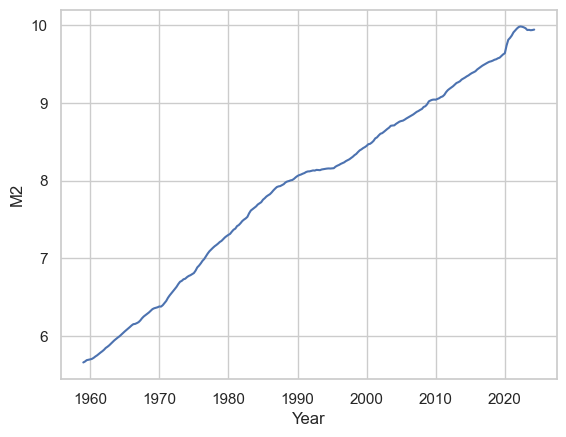

In [270]:
# Plotting money

fig, ax = plt.subplots()
ax.plot("M2", data=money)
ax.set_xlabel("Year")
ax.set_ylabel("M2")

# From pure observation, the time-series is probably not stationary

In [271]:
# Augmented Dickey-Fuller-Test is used for testing

result = adfuller(money["M2"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

# A p-value which is equal to one is very unlikely but possible due to rounding
# The time-series is non-stationary, because we cannot reject the null-hypothesis

ADF Statistic: -1.637295
p-value: 0.463674
Critical values:
  1% -3.4564641849494113
Critical values:
  5% -2.873032730098417
Critical values:
  10% -2.572894516864816


In [272]:
# Differencing the time-series to achieve stationarity

money_diff = money.copy()

money_diff["M2"] = money["M2"].diff().copy()

In [273]:
# Drop the row with the missing value

money_diff = money_diff.dropna().copy()

# Again testing for stationarity

result = adfuller(money_diff["M2"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

# The p-value > 0.05, the time-series is now stationary after differencing for one time
# The time-series is therefore integrated by order 1: I(1)

ADF Statistic: -5.261043
p-value: 0.000007
Critical values:
  1% -3.4564641849494113
Critical values:
  5% -2.873032730098417
Critical values:
  10% -2.572894516864816


Text(0, 0.5, 'M2-diff')

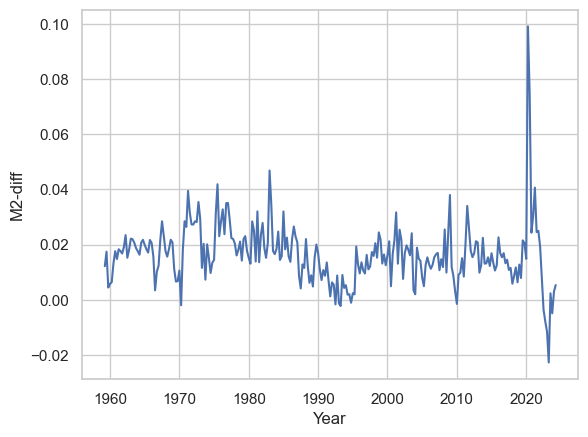

In [274]:
# Plotting the time-series again

fig, ax = plt.subplots()
ax.plot("M2", data=money_diff)
ax.set_xlabel("Year")
ax.set_ylabel("M2-diff")

### Testing inflation-dataset for stationarity

Text(0, 0.5, 'CPI')

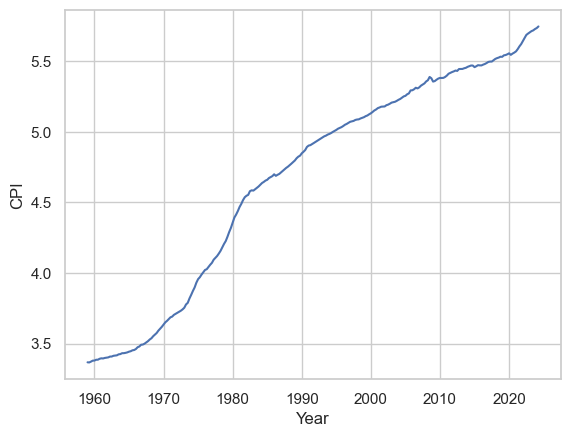

In [275]:
# Plotting inflation (CPI)

fig, ax = plt.subplots()
ax.plot("inflation", data=inflation)
ax.set_xlabel("Year")
ax.set_ylabel("CPI")

# From pure observation, the time-series is probably not stationary

In [276]:
# Augmented Dickey-Fuller-Test is used for testing

result = adfuller(inflation["inflation"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

# The time-series is non-stationary, because we cannot reject the null-hypothesis

ADF Statistic: -1.321145
p-value: 0.619444
Critical values:
  1% -3.455952927706342
Critical values:
  5% -2.8728086526320302
Critical values:
  10% -2.572774990685656


In [277]:
# Differencing the time-series to achieve stationarity

inflation_diff = inflation.copy()

inflation_diff["inflation"] = inflation["inflation"].diff().copy()

In [278]:
# Drop the row with the missing value

inflation_diff = inflation_diff.dropna().copy()

# Again testing for stationarity

result = adfuller(inflation_diff["inflation"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

# The p-value > 0.05, the time-series is now stationary after differencing for one time
# The time-series is therefore integrated by order 1: I(1)

ADF Statistic: -3.711497
p-value: 0.003954
Critical values:
  1% -3.455952927706342
Critical values:
  5% -2.8728086526320302
Critical values:
  10% -2.572774990685656


Text(0, 0.5, 'inflation')

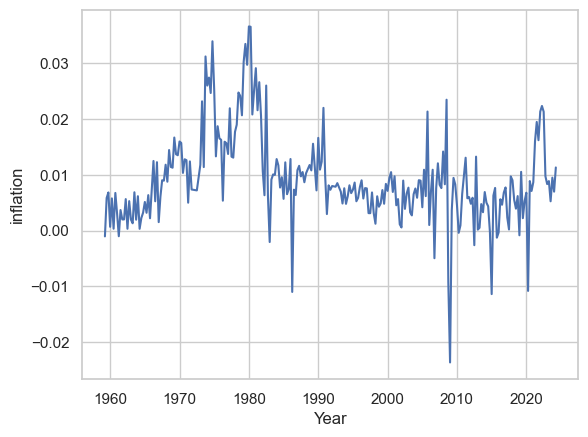

In [279]:
# Plotting the time-series again

fig, ax = plt.subplots()
ax.plot("inflation", data=inflation_diff)
ax.set_xlabel("Year")
ax.set_ylabel("inflation")

### Testing gdp-dataset for stationarity

Text(0, 0.5, 'gdp')

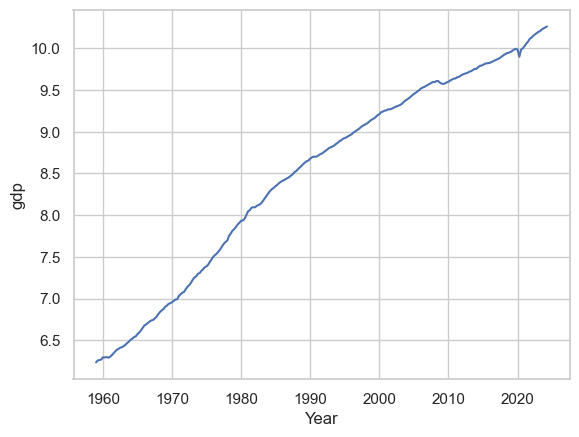

In [280]:
# Plotting inflation (CPI)

fig, ax = plt.subplots()
ax.plot("gdp", data=gdp)
ax.set_xlabel("Year")
ax.set_ylabel("gdp")

# From pure observation, the time-series is probably not stationary

In [281]:
# Augmented Dickey-Fuller-Test is used for testing

result = adfuller(gdp["gdp"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

# The time-series is weakly stationary, because we can reject the null-hypothesis
# Because of this weak stationarity (the plot clearly shows non-stationarity) we difference the time-series

ADF Statistic: -3.365814
p-value: 0.012181
Critical values:
  1% -3.4558530692911504
Critical values:
  5% -2.872764881778665
Critical values:
  10% -2.572751643088207


In [282]:
# Differencing the time-series to achieve stationarity

gdp_diff = gdp.copy()

gdp_diff["gdp"] = gdp["gdp"].diff().copy()

In [283]:
# Drop the row with the missing value

gdp_diff = gdp_diff.dropna().copy()

# Again testing for stationarity

result = adfuller(gdp_diff["gdp"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

# The p-value > 0.05, the time-series is now stationary after differencing for one time
# The time-series is therefore integrated by order 1: I(1)

ADF Statistic: -5.587635
p-value: 0.000001
Critical values:
  1% -3.4560535712549925
Critical values:
  5% -2.8728527662442334
Critical values:
  10% -2.5727985212493754


Text(0, 0.5, 'gdp-diff')

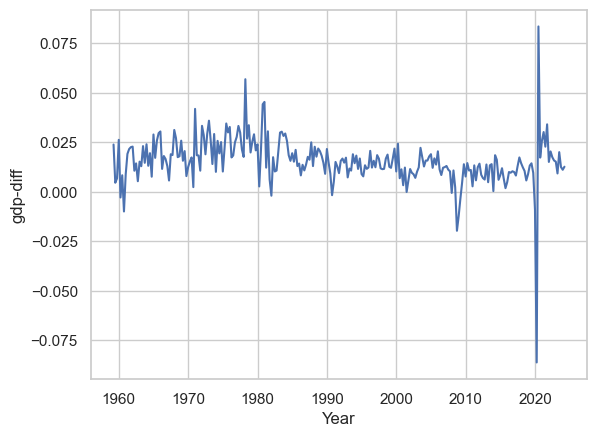

In [284]:
# Plotting the time-series again

fig, ax = plt.subplots()
ax.plot("gdp", data=gdp_diff)
ax.set_xlabel("Year")
ax.set_ylabel("gdp-diff")

### Determining the optimal amount of lags for the VAR-Model

In [285]:
# First, merge the datasets to one dataset

df = pd.merge(money_diff, inflation_diff, left_index=True, right_index=True)

In [286]:
df_final = pd.merge(df, gdp_diff, left_index=True, right_index=True)

df_final = df_final.rename(columns={"M2": "M2_diff_2", "inflation": "inflation_diff", "gdp": "gdp_diff"})

In [287]:
# The frequency for the dataset must be determined

df_final = df_final.asfreq("QS").copy()

In [288]:
model = VAR(df_final)

lag_order = model.select_order(maxlags=15)
print(lag_order.summary())

# 2 lags are optimal for the VAR-Model

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -27.58      -27.54   1.049e-12      -27.57
1       -28.82      -28.65   3.044e-13      -28.75
2       -29.01     -28.71*   2.524e-13      -28.89
3      -29.06*      -28.63  2.392e-13*     -28.89*
4       -29.02      -28.47   2.490e-13      -28.80
5       -29.00      -28.31   2.552e-13      -28.72
6       -28.94      -28.12   2.712e-13      -28.61
7       -28.88      -27.94   2.868e-13      -28.50
8       -28.89      -27.82   2.857e-13      -28.46
9       -28.84      -27.65   2.988e-13      -28.36
10      -28.82      -27.50   3.053e-13      -28.29
11      -28.80      -27.35   3.110e-13      -28.22
12      -28.78      -27.20   3.179e-13      -28.15
13      -28.74      -27.03   3.331e-13      -28.05
14      -28.68      -26.85   3.526e-13      -27.94
15      -28.67      -26.70   3.599e-13      -27.87
-------------------------------

In [289]:
model_fit = model.fit(maxlags=2)

model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 14, Aug, 2024
Time:                     09:53:56
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -28.7705
Nobs:                     259.000    HQIC:                  -28.9430
Log likelihood:           2681.62    FPE:                2.39821e-13
AIC:                     -29.0589    Det(Omega_mle):     2.21381e-13
--------------------------------------------------------------------
Results for equation M2_diff_2
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.005873         0.001418            4.141           0.000
L1.M2_diff_2              0.515964         0.065738            7.849           0.000
L1.inflation_diff         0.025469      

### Analysis of residuals

In [290]:
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import jarque_bera

resid_money = model_fit

In [291]:
# First, the Jarque-Bera-test for normality of residuals

resid = model_fit.resid

jb_test = jarque_bera(resid)
print(f"p-value: {jb_test[1]}")

# JB-test shows, that none of the residuals is distributed normally
# But because our sample of observations is large enough, the CLT lets us assume normality for the distribution of coefficients

p-value: [0.00000000e+00 2.92449226e-23 0.00000000e+00]


In [292]:
# Now, the White-test is used to analyze the variance of the residuals


# White-test for money supply M2
exog_money = pd.DataFrame({f'lag_{i}': df_final["M2_diff_2"].shift(i) for i in range(1, 2)}).dropna()
residuals_money = resid["M2_diff_2"][-len(exog_money):]
exog_money = sm.add_constant(exog_money)

white_test = het_white(residuals_money, exog_money.iloc[1:])
print(f'White test statistic: {white_test[0]}, p-value: {white_test[1]}')

# The residuals for the money supply were strongly heteroscedastic
# After log-transformation, they are homoscedastic

White test statistic: 0.009790950582383884, p-value: 0.9951164880179817


In [293]:
# White-test for inflation
exog_inflation = pd.DataFrame({f'lag_{i}': df_final["inflation_diff"].shift(i) for i in range(1, 2)}).dropna()
residuals_inflation = resid["M2_diff_2"][-len(exog_inflation):]
exog_inflation = sm.add_constant(exog_inflation)

white_test = het_white(residuals_inflation, exog_inflation.iloc[1:])
print(f'White test statistic: {white_test[0]}, p-value: {white_test[1]}')

# The residuals for the inflation are homoscedastic

White test statistic: 0.03601664103645463, p-value: 0.9821528603035268


In [294]:
# White-test for gdp
exog_gdp = pd.DataFrame({f'lag_{i}': df_final["gdp_diff"].shift(i) for i in range(1, 2)}).dropna()
residuals_gdp = resid["M2_diff_2"][-len(exog_gdp):]
exog_gdp = sm.add_constant(exog_gdp)

white_test = het_white(residuals_gdp, exog_gdp.iloc[1:])
print(f'White test statistic: {white_test[0]}, p-value: {white_test[1]}')

# The residuals for gdp were strongly heteroscedastic
# After log-transformation, they are homoscedastic

White test statistic: 3.1148498513618827, p-value: 0.21067788450658917


-> The data will be log-transformed to reduce strong heteroscedasticity of residuals

-> After log-transformation, the residuals are no longer heteroscedastic

In [295]:
# The whiteness-test for testing for autocorrelation of residuals is conducted (best for VAR-model)
# This test requires a large sample size, but the sample size of about 260 observations is enough here

# Whiteness-test: sqrt(T) as number of lags

lags = sqrt(261) # = 16.155; gets rounded to 16 lags


In [296]:
whiteness_test = model_fit.test_whiteness(nlags=16, signif=0.05)

whiteness_test.summary()

# Test shows no autocorrelation for VAR-model

Test statistic,Critical value,p-value,df
141.9,153.2,0.157,126


-> After the analysis of residuals, the estimated VAR-model seems to be fit for further analysis

### IRF-Analysis

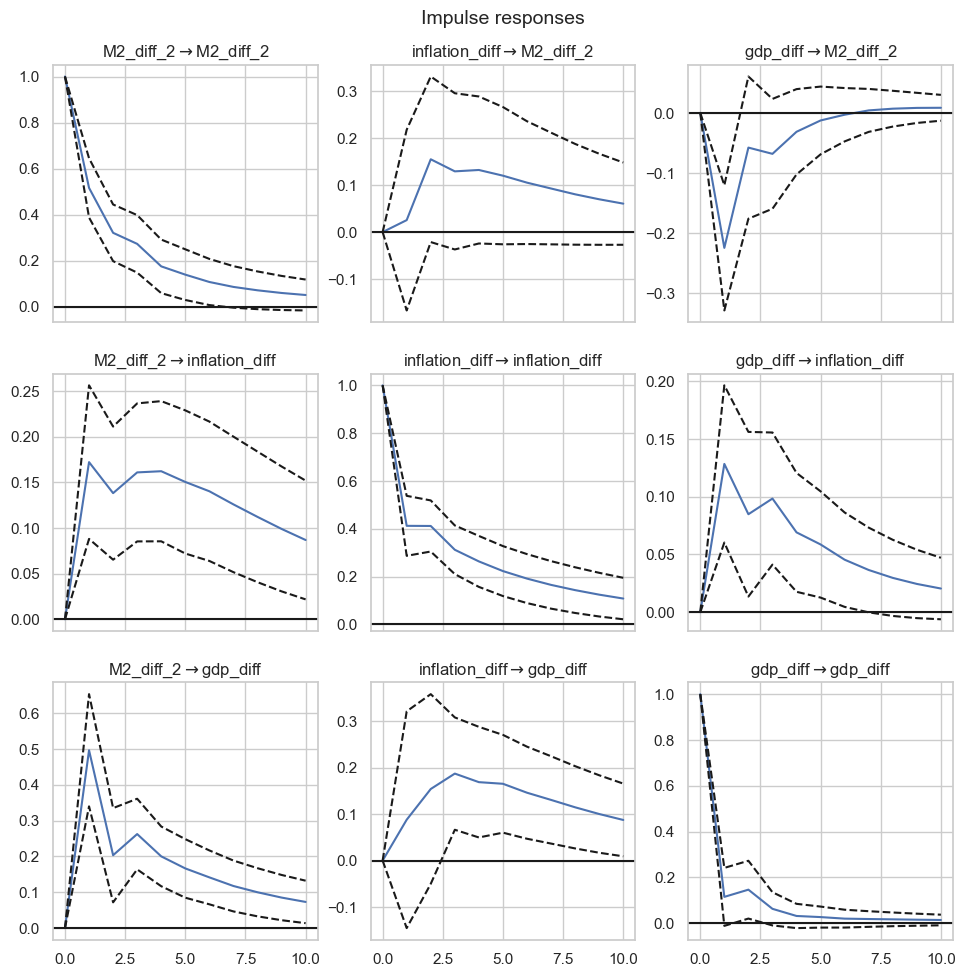

In [316]:
irf = model_fit.irf(10)

irf.plot(orth=False)
plt.show()